In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/Users/daisy/Desktop/Purdue/590 Computing for Analytics/Final Project/filtered_data 1.csv")

### Identify Top Stations: 
This gets the top 10 most frequent used starting and ending stations using .value_counts().
- df['start_station_name'] is a column listing the starting station for each trip.
- .value_counts() counts how many times each station name appears in that column.
- This can answer "How many trips ended at this station?" and "How many trips started at this station?" and 

In [3]:
top_start_stations = df['start_station_name'].value_counts().nlargest(10).index
top_end_stations = df['end_station_name'].value_counts().nlargest(10).index

In [19]:
print("Top 10 most frequent start station : ",top_start_stations)
print("Top 10 most frequent end station : ",top_end_stations)

Top 10 most frequent start station :  Index(['Belgrove Street , King's Cross', 'Waterloo Station 3, Waterloo',
       'Waterloo Station 1, Waterloo', 'Hyde Park Corner, Hyde Park',
       'Wormwood Street, Liverpool Street',
       'Finsbury Circus, Liverpool Street', 'Queen Street 1, Bank',
       'Brushfield Street, Liverpool Street', 'Hop Exchange, The Borough',
       'Cheapside, Bank'],
      dtype='object', name='start_station_name')
Top 10 most frequent end station :  Index(['Belgrove Street , King's Cross', 'Waterloo Station 3, Waterloo',
       'Waterloo Station 1, Waterloo', 'Hop Exchange, The Borough',
       'Wormwood Street, Liverpool Street',
       'Finsbury Circus, Liverpool Street', 'Newgate Street , St. Paul's',
       'Brushfield Street, Liverpool Street', 'Hyde Park Corner, Hyde Park',
       'Queen Street 1, Bank'],
      dtype='object', name='end_station_name')


### Filter the Data
Filters rows to include only trips that start and end at one of the top 10 popular stations.

In [5]:
filtered_df = df[df['start_station_name'].isin(top_start_stations) & df['end_station_name'].isin(top_end_stations)]

### Build the Directed Graph
- Each node is a station
- Each edge is a trip from one station to another
- Edge weight = how many times that trip has occurred in the data

In [6]:
G = nx.DiGraph()
for _, row in filtered_df.iterrows():
    u = row['start_station_name']
    v = row['end_station_name']
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u, v, weight=1)

###  Compute PageRank
Answer "How important a station is in the network" by calculating both quality and quantity of the connections.

In [7]:
pagerank_scores = nx.pagerank(G, weight='weight')


In [22]:
# Find top-scoring station
top_station = max(pagerank_scores, key=pagerank_scores.get)
top_score = pagerank_scores[top_station]

print(f"Top station by PageRank: {top_station}")
print(f"PageRank score: {top_score:.6f}")

Top station by PageRank: Hyde Park Corner, Hyde Park
PageRank score: 0.168236


### Compute Degree Centrality

How "connected" each station (node) is within the network. This helps we identify hub stations in our bikeshare system. (Answering "How connected a station is" by calculating the number of the connection)

In [8]:
centrality_scores = nx.degree_centrality(G)


In [21]:
# Sort centrality scores in descending order
top_station = max(centrality_scores, key=centrality_scores.get)
top_score = centrality_scores[top_station]

print(f"Top station by centrality: {top_station}")
print(f"Centrality score: {top_score:.4f}")


Top station by centrality: Hop Exchange, The Borough
Centrality score: 2.0000


### Visualize the Network

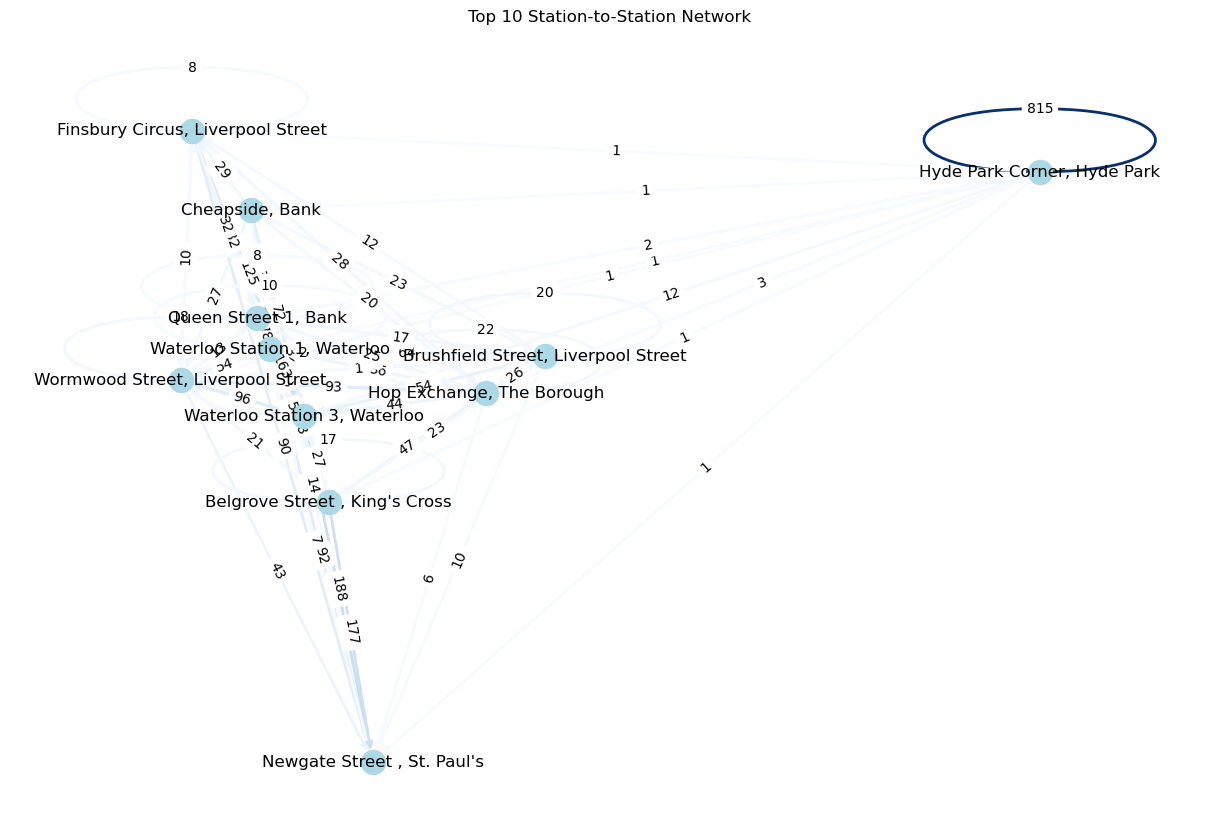

In [9]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})
plt.title("Top 10 Station-to-Station Network")
plt.show()


### insight from Q1
Insight #1: Hyde Park Corner is a self-contained hub
- Evidence: The edge loop (a circular arrow) shows 815 trips starting and ending at Hyde Park Corner, Hyde Park.

- Implication: This location likely hosts casual or leisure riders who return bikes to the same station — suggesting proximity to a park or tourist attraction.

- Use case: The operator could place more bikes here during peak recreational hours (e.g., weekends or lunch breaks).

Insight #2: Newgate Street, St. Paul's is a central destination
- Evidence: Strong edge weights like 188, 177, and 92 show many trips ending here from stations like King's Cross and Waterloo.

- Implication: This station is a commuter destination — likely near offices or a transport interchange.

- Use case: Consider rebalancing strategies in the morning and post-commute hours to accommodate directional traffic.